In [51]:
# 1) quasi random numbers
# 2) importance sampling: sample from the region of the tail (look for extremes) that is most important, this will reduce variance 

BASELINE

In [7]:
import numpy as np, pandas as pd, scipy.stats as st

In [8]:
data = pd.read_csv('data.csv')
num_obvs = 30000
# risks per sector
r = np.array([.295, .49, .41, .415, .338, .64, .403, .476])
#sec_loading maps sector to its risk, t is the threshold for defaults
data['sec_loading'], data['t'] = r[data['sector'].values], st.norm.ppf(data.p)
# 100k monte carlo simulations and len(r)+len(data) risk factors per one sample
factors, sample = np.random.normal(0,1, (num_obvs, len(r)+len(data))), []

In [9]:
vars = []

In [10]:
for obs in factors:
    m_factor, sec_factor, res_factor = obs[0], obs[:len(r)][data.sector.values], obs[len(r):]
    ind = r[0]**.5 * m_factor + (data.sec_loading-r[0])**.5 * sec_factor + (1-
                                                                            data.sec_loading)**.5 * res_factor < data.t
    loss = np.zeros((len(data),))
    loss[ind] = data[ind].m + data[ind].d * np.random.standard_t(3, size=sum(ind
                                                                             ))
    sample.append(sum(loss))
    vars.append(np.var(loss))

In [11]:
# extracts the 1% quantile from the sorted list of 100k obsercations
VaR = sorted([-s for s in sample])[100]

In [12]:
VaR

-12307.810664663319

In [13]:
np.mean(vars)

1400.7975964737664

IMPORTANCE SELECTION

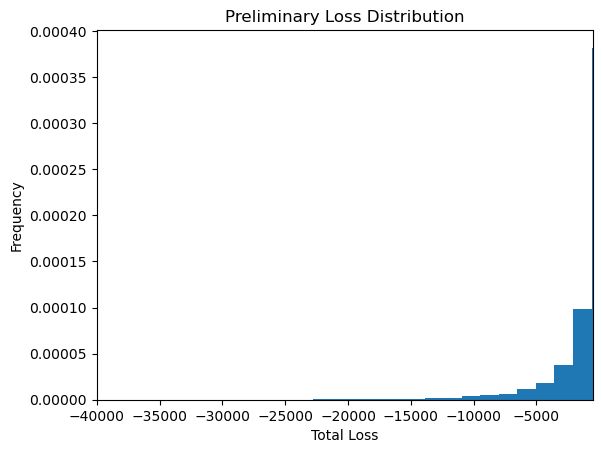

In [68]:
import matplotlib.pyplot as plt

plt.hist(sample, bins=50, density=True)
plt.title("Preliminary Loss Distribution")
plt.xlabel("Total Loss")
plt.ylabel("Frequency")
plt.xlim(-40000,-500)
plt.show()

In [65]:
data

,sector,m,d,p,sec_loading,t
0,5,-7.417203,0.631652,0.015994,0.64,-2.144549
1,2,-527.362999,49.292996,0.005138,0.41,-2.566434
2,2,-439.116574,42.366041,0.005386,0.41,-2.550002
3,5,112.839687,13.193781,0.016846,0.64,-2.123749
4,5,93.661362,14.562288,0.017555,0.64,-2.107093
...,...,...,...,...,...,...
5653,5,81.071783,3.121474,0.014192,0.64,-2.191924
5654,5,-29.621411,4.334980,0.015017,0.64,-2.169647
5655,5,71.006290,8.699961,0.014092,0.64,-2.194725
5656,5,102.410688,14.274780,0.017539,0.64,-2.107466


HEREZJA SOBOL

In [59]:
num_dimensions = len(r) + len(data)

In [60]:
from scipy.stats import qmc
sobol_sampler = qmc.Sobol(d=num_dimensions, scramble=True)
quasi_random_samples = sobol_sampler.random_base2(m=int(np.log2(num_obvs)))

In [61]:
from scipy.stats import norm
factors = st.norm.ppf(quasi_random_samples)

In [62]:
from scipy.stats import t
sample = []
sobol_student= qmc.Sobol(d=1, scramble=True)
for obs in factors:
    # m_factor, sec_factor, res_factor = obs[0], obs[1:1 + len(r)][data.sector.values], obs[len(r):]
    m_factor, sec_factor, res_factor = obs[0], obs[:len(r)][data.sector.values], obs[len(r):]

    ind = (
                  r[0]**0.5 * m_factor
                  + (data.sec_loading - r[0])**0.5 * sec_factor
                  + (1 - data.sec_loading)**0.5 * res_factor
          ) < data.t
    loss = np.zeros((len(data),))
    stt=sobol_student.random(n=sum(ind)).flatten()
    stud = st.t.ppf(stt,3)
    loss[ind] = data[ind].m + data[ind].d * stud
    sample.append(sum(loss))

/Users/babybones/anaconda3/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [63]:
VaR = sorted([-s for s in sample])[int(0.01 * num_obvs)]

In [64]:
VaR

-5487.654569494339

PARALLEL

In [2]:
import numpy as np, pandas as pd, scipy.stats as st

data = pd.read_csv('data.csv')
num_obvs = 100000
# risks per sector
r = np.array([.295, .49, .41, .415, .338, .64, .403, .476])
#sec_loading maps sector to its risk, t is the threshold for defaults
data['sec_loading'], data['t'] = r[data['sector'].values], st.norm.ppf(data.p)
# 100k monte carlo simulations and len(r)+len(data) risk factors per one sample
num_dimensions = len(r) + len(data)
from scipy.stats import qmc

sobol_sampler = qmc.Sobol(d=num_dimensions, scramble=True)
quasi_random_samples = sobol_sampler.random_base2(m=int(np.log2(num_obvs)))
from scipy.stats import norm

factors = st.norm.ppf(quasi_random_samples)


def process_obs(obs):
    # m_factor, sec_factor, res_factor = obs[0], obs[1:1 + len(r)][data.sector.values], obs[len(r):]
    m_factor, sec_factor, res_factor = obs[0], obs[:len(r)][data.sector.values], obs[len(r):]

    ind = (
                  r[0] ** 0.5 * m_factor
                  + (data.sec_loading - r[0]) ** 0.5 * sec_factor
                  + (1 - data.sec_loading) ** 0.5 * res_factor
          ) < data.t
    loss = np.zeros((len(data),))
    stt = sobol_student.random(n=sum(ind)).flatten()
    stud = st.t.ppf(stt, 3)
    loss[ind] = data[ind].m + data[ind].d * stud
    return sum(loss)


from joblib import Parallel, delayed
import time
from scipy.stats import t

sample = []
sobol_student = qmc.Sobol(d=1, scramble=True)

sample = Parallel(n_jobs=-1)(delayed(process_obs)(obs) for obs in factors)
VaR = sorted([-s for s in sample])[int(0.01 * num_obvs)]
VaR


-6368.386171852054